- "ada:ft-personal-2023-03-17-19-05-55"
- "ada:ft-personal-2023-03-21-18-34-25"
  - I think this is the final model

In [1]:
ft_model = "ada:ft-personal-2023-03-21-18-34-25"

In [4]:
import pandas as pd
import openai
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [3]:
api_key = os.getenv("OPENAI_API_KEY")
print(type(api_key))
openai.api_key = api_key

df = pd.read_excel("human_ai.xlsx")

df.to_json("ai.jsonl", orient='records', lines=True)

# !openai tools fine_tunes.prepare_data -f ai.jsonl -q

# !openai api fine_tunes.create -t "ai_prepared_train.jsonl" -v "ai_prepared_valid.jsonl" -m ada --compute_classification_metrics --classification_positive_class " human" --n_epochs 10

# !openai api fine_tunes.results -i ft-B29wadYuk9CqMvVvKJKQ4P5u > student_result5.csv

<class 'str'>


      step  elapsed_tokens  elapsed_examples  training_loss  \
0        1             585                 1       0.071334   
1        2            1570                 2       0.051142   
2        3            2467                 3       0.044245   
3        4            3348                 4       0.048229   
4        5            4453                 5       0.028044   
...    ...             ...               ...            ...   
3546  3547         3196715              3547       0.004662   
3547  3548         3197412              3548       0.005026   
3548  3549         3198397              3549       0.004665   
3549  3550         3199070              3550       0.002380   
3550  3551         3199967              3551       0.004751   

      training_sequence_accuracy  training_token_accuracy  validation_loss  \
0                            0.0                      0.0         0.055746   
1                            0.0                      0.0              NaN   
2        

<Axes: >

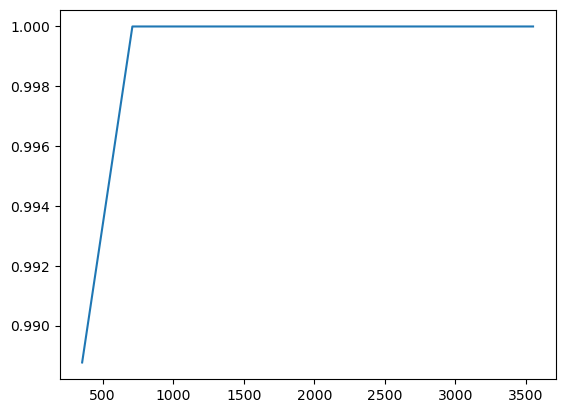

In [5]:
results = pd.read_csv('ai_result2.csv')

print(results)

print(results[results['classification/accuracy'].notnull()].tail(1))

results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

<Axes: >

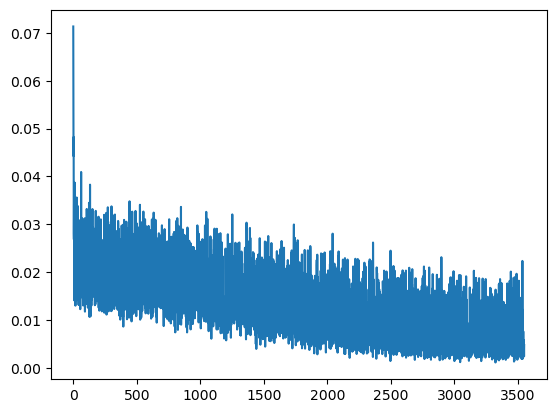

In [6]:
results[results['training_loss'].notnull()]['training_loss'].plot()

In [9]:
test = pd.read_json('ai_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,\n\nWomen in the Ancient World\n\nThroughout h...,ai
1,\n\nThe Winter Goddess\n\nWinter is a season t...,ai
2,\n\nAnglo-Saxon Studies [Early English Studies...,ai
3,The Division of Labour\n\nThe division of labo...,ai
4,\n\nThe Quatrian Grand Theatre is a landmark b...,ai


In [12]:
classes = list(test['completion'].unique())
print(classes)

[' ai', ' human']


In [13]:
for i in range(len(test)):
    res = openai.Completion.create(model=ft_model, prompt=test['prompt'][i] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
    test.loc[i, 'prediction'] = res['choices'][0]['text']
    #test.loc[i, 'log_probs'] = res['choices'][0]['logprobs']['top_logprobs'][0]

print(test.head(20))

                                               prompt completion prediction
0   \n\nWomen in the Ancient World\n\nThroughout h...         ai          a
1   \n\nThe Winter Goddess\n\nWinter is a season t...         ai          a
2   \n\nAnglo-Saxon Studies [Early English Studies...         ai          a
3   The Division of Labour\n\nThe division of labo...         ai          a
4   \n\nThe Quatrian Grand Theatre is a landmark b...         ai          a
5   \n\nRushing the Growler\n\nHave you ever heard...         ai          a
6   \n\nAnglo-Saxon Studies, also known as Early E...         ai          a
7   \n\nYes the Body: A Quarantined Review of Spaw...         ai          a
8   \n\nBasketball is one of the most popular spor...         ai          a
9   \n\nAesopica is a collection of fables attribu...         ai          a
10  \n\nSeventy-five years ago, the world witnesse...         ai          a
11  \n\nCovid-19 Live Updates: Americans Gather fo...         ai          a
12  \n\nLine

In [14]:
classes = list(test['prediction'].unique())
classes

[' a', ' human']

Predicted   aii   humaiin
Actual                   
 ai          59         0
 human        0        11


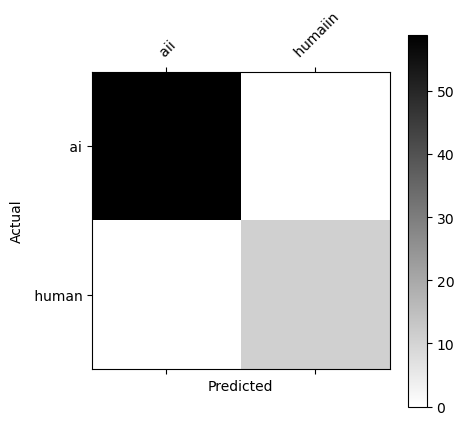

In [16]:
test['prediction'] = test['prediction'].str.replace('a', 'ai')

y_actu = pd.Series(test['completion'].values, name='Actual')
y_pred = pd.Series(test['prediction'].values, name='Predicted')

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
plot_confusion_matrix(df_confusion)